In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pickle

In [ ]:
data = pd.read_csv("cumulative.csv")
print(data.columns)

In [ ]:
print(data.info())

In [ ]:
data.isnull().any()

In [ ]:
transit_related_features = ['koi_period', 'koi_duration', 'koi_depth', 'koi_impact', 'koi_prad', 'koi_model_snr']
stellar_features = ['koi_steff', 'koi_slogg', 'koi_srad', 'koi_kepmag']
useful_features = transit_related_features + stellar_features + ['koi_score', 'koi_disposition', 'koi_pdisposition']

In [ ]:
data = data[useful_features]

In [ ]:
data.isnull().any()

In [ ]:
data.fillna(data.median(),inplace=True)

In [ ]:
data.isnull().any()

In [ ]:
data.head()

In [ ]:
def get_combined_disposition(row):
    if row['koi_disposition'] == 'CONFIRMED':
        return 2  # Confirmed exoplanet
    elif row['koi_pdisposition'] == 'CANDIDATE':
        return 1  # Candidate exoplanet
    else:
        return 0  # False positive


data['confirmation_label'] = data.apply(get_combined_disposition, axis=1)

In [ ]:
bins=[0,0.33,0.66,1.0]
labels = ["low","medium","high"]
data['confidence_label']=pd.cut(data['koi_score'],bins=bins,labels=labels,right=True)
data.loc[data['koi_score'] == 0, 'confidence_label'] = 'low'
data

In [ ]:
data["confidence_label"]=data["confidence_label"].map({
    'low':0,
    'medium':1,
    'high':2
})

data

In [ ]:
X = data[transit_related_features+ stellar_features]

In [ ]:
scaler = StandardScaler()
X_scaled= scaler.fit_transform(X)

In [ ]:
X_train_conf,X_test_conf,y_train_conf,y_test_conf = train_test_split(X_scaled,data['confirmation_label'],test_size=0.2,random_state=42)
X_train_confidence,X_test_confidence,y_train_confidence,y_test_confidence = train_test_split(X_scaled,data['confidence_label'],test_size=0.2,random_state=42)

In [ ]:
rf_model_conf = RandomForestClassifier(random_state=42)
rf_model_confidence =RandomForestClassifier(random_state=42)

In [21]:
rf_model_conf.fit(X_train_conf,y_train_conf)
rf_model_confidence.fit(X_train_confidence,y_train_confidence)

RandomForestClassifier(random_state=42)

In [22]:
y_pred_conf = rf_model_conf.predict(X_test_conf)
y_pred_confidence = rf_model_confidence.predict(X_test_confidence)

In [23]:
print("Exoplanet Confirmation:")
print("Accuracy:", accuracy_score(y_test_conf, y_pred_conf))
print("Confusion Matrix:\n", confusion_matrix(y_test_conf, y_pred_conf))
print("Classification Report:\n", classification_report(y_test_conf, y_pred_conf))

print("\nDisposition Confidence:")
print("Accuracy:", accuracy_score(y_test_confidence, y_pred_confidence))
print("Confusion Matrix:\n", confusion_matrix(y_test_confidence, y_pred_confidence))
print("Classification Report:\n", classification_report(y_test_confidence, y_pred_confidence))

Exoplanet Confirmation:
Accuracy: 0.7689492943021432
Confusion Matrix:
 [[873  84  51]
 [144 211  96]
 [ 20  47 387]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      1008
           1       0.62      0.47      0.53       451
           2       0.72      0.85      0.78       454

    accuracy                           0.77      1913
   macro avg       0.73      0.73      0.72      1913
weighted avg       0.76      0.77      0.76      1913


Disposition Confidence:
Accuracy: 0.7935180345007841
Confusion Matrix:
 [[634  56 120]
 [ 72 217  58]
 [ 62  27 667]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80       810
           1       0.72      0.63      0.67       347
           2       0.79      0.88      0.83       756

    accuracy                           0.79      1913
   macro avg       0.78      0.76      0.77      1913
weighted

In [24]:
# Simplified parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],  # Fewer estimators to try
    'max_depth': [None, 10, 20],  # Simplified depth range
    'min_samples_split': [2, 5],  # Reduced options for min samples split
    'min_samples_leaf': [1, 2],  # Reduced options for min samples leaf
    'bootstrap': [True, False]  # Bootstrap options
}

# Set up RandomizedSearchCV
randomized_search_conf = RandomizedSearchCV(
    estimator=rf_model_conf,
    param_distributions=param_grid,
    n_iter=10,  # Limit the number of combinations to try
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Run the randomized search
randomized_search_conf.fit(X_train_conf, y_train_conf)

# Get the best parameters
print("\nBest parameters (Exoplanet Confirmation):", randomized_search_conf.best_params_)

# Re-train with best parameters
best_rf_model_conf = randomized_search_conf.best_estimator_
best_rf_model_conf.fit(X_train_conf, y_train_conf)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters (Exoplanet Confirmation): {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}


RandomForestClassifier(min_samples_leaf=2, min_samples_split=5, random_state=42)

In [25]:
y_final_pred_conf = best_rf_model_conf.predict(X_test_conf)
print("\nFinal Model Accuracy (Exoplanet Confirmation):", accuracy_score(y_test_conf, y_final_pred_conf))



Final Model Accuracy (Exoplanet Confirmation): 0.7584945112388918


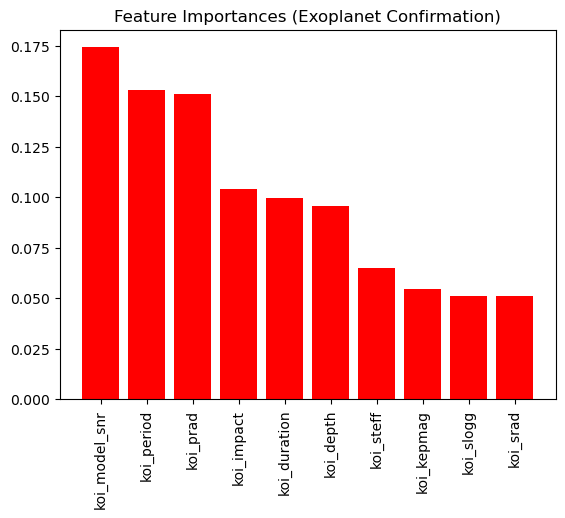

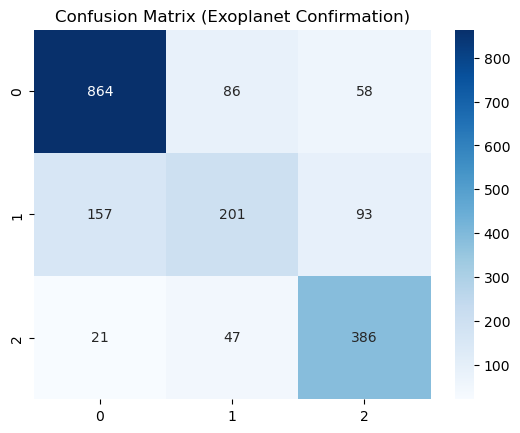

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine the feature names into a single list
feature_names = transit_related_features + stellar_features

# Get the importance of each feature
importances = best_rf_model_conf.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort the feature importances in descending order

# Plot the feature importances
plt.figure()
plt.title("Feature Importances (Exoplanet Confirmation)")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")

# Corrected line: Use the combined list for feature names
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.show()
# Confusion Matrix for the Final Model
sns.heatmap(confusion_matrix(y_test_conf, y_final_pred_conf), annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix (Exoplanet Confirmation)')
plt.show()

In [27]:

# Save your trained stacking model
with open('model/best_rf_model_conf.pkl', 'wb') as file:
    pickle.dump(best_rf_model_conf, file)
    
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_conf)

# Save the scaler
with open('model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)